## How to use this notebook

There are several alternative ways in which you can use this notebook.
1. Access online here [![Binder](http://mybinder.org/badge.svg)](http://mybinder.org/repo/salib/satut) (changes won't be saved)
2. [Download](http://www.github.com/SALib/SATut) the notebooks, and install jupyter and python
    1. For Mac, open terminal and type
        ```bash
        pip install jupyter notebook ipython
        ```
    2. Then
        ```bash
        jupyter notebook
        ```

# In this work we will see how SALib can be applied to analyze the weight of different factors in model.py

# Import basic components from IPython library

In [8]:
from ipywidgets import widgets, interact
from IPython.display import display
%matplotlib inline
import seaborn as sbn
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.pylabtools import figsize
figsize(12, 10)
sbn.set_context("talk", font_scale=1)

# The model used for this seminar is contained in the file model.py
from model import (cost_of_vehicle_to_grid, compute_profit, 
                   annualized_capital_cost, battery_lifetime, 
                   max_vehicle_power)
import pandas as pd
file_path = 'car_information.csv'
df = pd.read_csv(file_path)

# Import morris from SALib

SALib is a **free** **open-source** **Python** library

If you use Python, you can install it by running the command

```python
pip install SALib
```

[Documentation](http://salib.readthedocs.org/) is available online and you can also view the code on [Github](http://salib.github.io/SALib/).

The library includes:
* Sobol Sensitivity Analysis ([Sobol 2001](http://www.sciencedirect.com/science/article/pii/S0378475400002706), [Saltelli 2002](http://www.sciencedirect.com/science/article/pii/S0010465502002801), [Saltelli et al. 2010](http://www.sciencedirect.com/science/article/pii/S0010465509003087))
* Method of Morris, including groups and optimal trajectories ([Morris 1991](http://www.tandfonline.com/doi/abs/10.1080/00401706.1991.10484804), [Campolongo et al. 2007](http://www.sciencedirect.com/science/article/pii/S1364815206002805))
* Fourier Amplitude Sensitivity Test (FAST) ([Cukier et al. 1973](http://scitation.aip.org/content/aip/journal/jcp/59/8/10.1063/1.1680571), [Saltelli et al. 1999](http://amstat.tandfonline.com/doi/abs/10.1080/00401706.1999.10485594))
* Delta Moment-Independent Measure ([Borgonovo 2007](http://www.sciencedirect.com/science/article/pii/S0951832006000883), [Plischke et al. 2013](http://www.sciencedirect.com/science/article/pii/S0377221712008995))
* Derivative-based Global Sensitivity Measure (DGSM) ([Sobol and Kucherenko 2009](http://www.sciencedirect.com/science/article/pii/S0378475409000354))
* Fractional Factorial Sensitivity Analysis ([Saltelli et al. 2008](http://www.wiley.com/WileyCDA/WileyTitle/productCd-0470059974.html))


In [9]:
from SALib.sample import morris as ms
from SALib.analyze import morris as ma
from SALib.plotting import morris as mp

In [10]:
def monte_carlo_large(data):
    dispatch_time = 4
    y = max_vehicle_power(data[0], data[1], data[2], data[3], data[6], data[4], data[5])
    return y

### Using morris in SALib to analyze the models

In [11]:
morris_problem = {
    # There are six variables
    'num_vars': 7,
    # These are their names
    'names': ['conn', 'batt', 'dist', 'range', 
              'dri_eff', 'inv_eff', 'dispatch_time'],
    # Plausible ranges over which we'll move the variables
    'bounds': [[2.3, 22], # connection_power (kW)
               [50, 100], # battery size (kWh)
               [0, 80], # distance driven (km)
               [0, 80], # range buffer (km)
               [4,5.5], # driving efficiency (kWh/km)
               [0.87,0.97], # inverter efficienct (%)
               [0.5, 24] # dispatch time - hours of the day in which 
                         # the energy is dispatched
              ],
    # I don't want to group any of these variables together
    'groups': None
    }

In [12]:
number_of_trajectories = 1000
sample = ms.sample(morris_problem, number_of_trajectories, num_levels=4)

### Factor Prioritisation

We'll run a sensitivity analysis of the power module to see which is the most influential parameter.

The results parameters are called **mu**, **sigma** and **mu_star**.

* **Mu** is the mean effect caused by the input parameter being moved over its range.
* **Sigma** is the standard deviation of the mean effect.
* **Mu_star** is the mean absolute effect.

In [13]:
# Run the sample through the monte carlo procedure of the power model
output = monte_carlo_large(sample.T)
# Store the results for plotting of the analysis
Si = ma.analyze(morris_problem, sample, output, print_to_console=False)
print("{:20s} {:>7s} {:>7s} {:>7s}".format("Name", "mu", "mu_star", "sigma"))
for name, s1, st, mean in zip(morris_problem['names'], 
                              Si['mu'], 
                              Si['mu_star'], 
                              Si['sigma']):
    print("{:20s} {:=7.2f} {:=7.2f} {:=7.2f}".format(name, s1, st, mean))

Name                      mu mu_star   sigma
conn                    6.47    6.47    8.39
batt                    1.85    1.85    1.97
dist                 -  0.62    0.62    0.67
range                -  0.66    0.66    0.72
dri_eff                 0.23    0.23    0.41
inv_eff                 0.24    0.24    0.28
dispatch_time        -  9.34    9.34    9.13


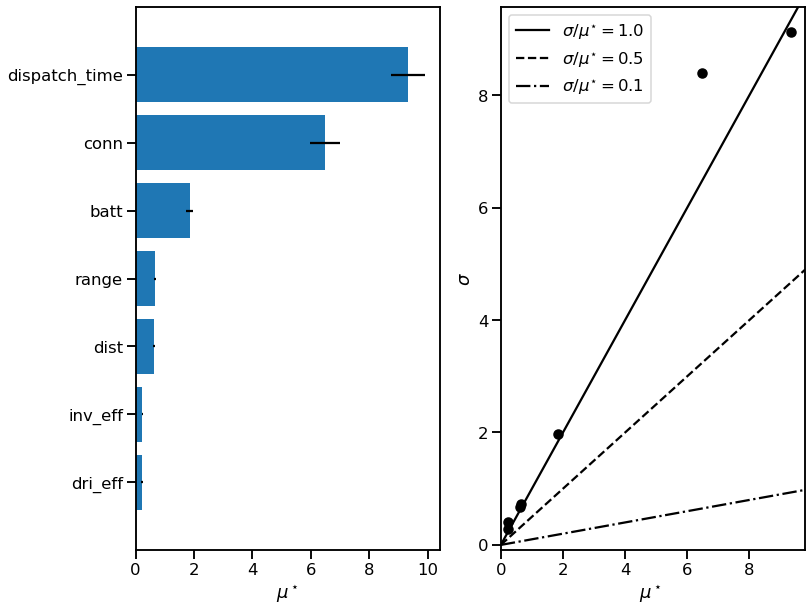

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2)
mp.horizontal_bar_plot(ax1, Si, {})
mp.covariance_plot(ax2, Si, {})

In [15]:
number_sims = 1000

# Make some random data in the correct ranges
mc_connector = np.random.uniform(2.3, 22, number_sims)
mc_battery_size = np.random.uniform(50, 100, number_sims)
mc_distance_driven = np.random.uniform(0, 80, number_sims)
mc_range_buffer = np.random.uniform(0, 80, number_sims)
mc_driving_eff = np.random.uniform(2, 6, number_sims)
mc_inv_eff = np.random.uniform(0.87, 0.97, number_sims)
mc_dispatch_time = np.random.uniform(0.5, 24, number_sims)

data = np.array((mc_connector, 
                 mc_battery_size, 
                 mc_distance_driven, 
                 mc_range_buffer, 
                 mc_driving_eff, 
                 mc_inv_eff, 
                 mc_dispatch_time))

# Run the code
y = monte_carlo_large(data)

# The datas will be organized in a manner in which the more related factor will be ranked higher.
We can see connector size is the factor the most related.

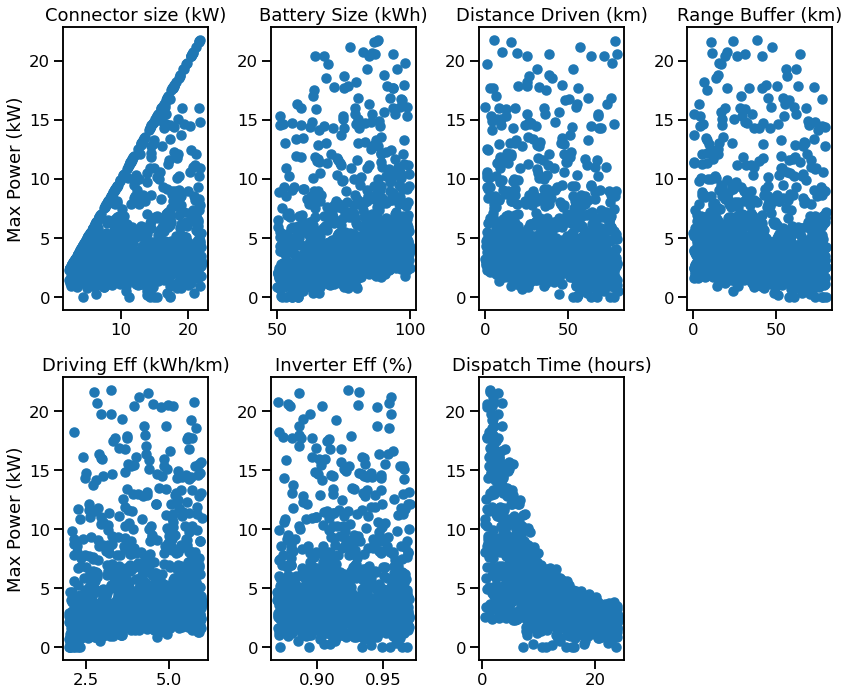

In [16]:
# Make some scatter plots to compare the results
plt.subplot(241)
plt.scatter(mc_connector, y)
plt.title("Connector size (kW)")
plt.ylabel("Max Power (kW)")
plt.subplot(242)
plt.scatter(mc_battery_size, y)
plt.title("Battery Size (kWh)")
# plt.ylabel("Max Power (kW)")
plt.subplot(243)
plt.scatter(mc_distance_driven, y)
plt.title("Distance Driven (km)")
# plt.ylabel("Max Power (kW)")
plt.subplot(244)
plt.scatter(mc_range_buffer, y)
plt.title("Range Buffer (km)")
# plt.ylabel("Max Power (kW)")
plt.subplot(245)
plt.scatter(mc_driving_eff, y)
plt.title("Driving Eff (kWh/km)")
plt.ylabel("Max Power (kW)")
plt.subplot(246)
plt.scatter(mc_inv_eff, y)
plt.title("Inverter Eff (%)")
# plt.ylabel("Max Power (kW)")
plt.subplot(247)
plt.scatter(mc_dispatch_time, y)
plt.title("Dispatch Time (hours)")
# plt.ylabel("Max Power (kW)")
plt.tight_layout()
# plt.savefig('scatter.png')